In [8]:
# 载入必要的库
import numpy as np
import tensorflow as tf
import keras

from matplotlib import pyplot as plt

from keras import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Flatten, Dropout, Dense, Input, Concatenate, add, Activation,ZeroPadding2D
from keras.layers import ReLU, DepthwiseConv2D
from tensorflow.keras.applications import VGG16

## 读取数据  Standford Dog

###  构建数据生成器

In [2]:
import random
random.seed(2020)

# Set image size
IMSIZE=112

# laod validation data
datagen = ImageDataGenerator(rescale=1. / 255,
                             shear_range=0.5,
                             rotation_range=30,
                             zoom_range=0.2,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split = 0.4)

validation_generator = datagen.flow_from_directory(
    '/course7/data/data_mob',
    target_size=(IMSIZE, IMSIZE),
    batch_size=100,
    class_mode='categorical',
    subset = 'validation')

train_generator = datagen.flow_from_directory(
    '/course7/data/data_mob',
    target_size=(IMSIZE, IMSIZE),
    batch_size=150,
    class_mode='categorical',
    subset = 'training')

Found 762 images belonging to 10 classes.
Found 1157 images belonging to 10 classes.


###  可视化

<Figure size 432x288 with 0 Axes>

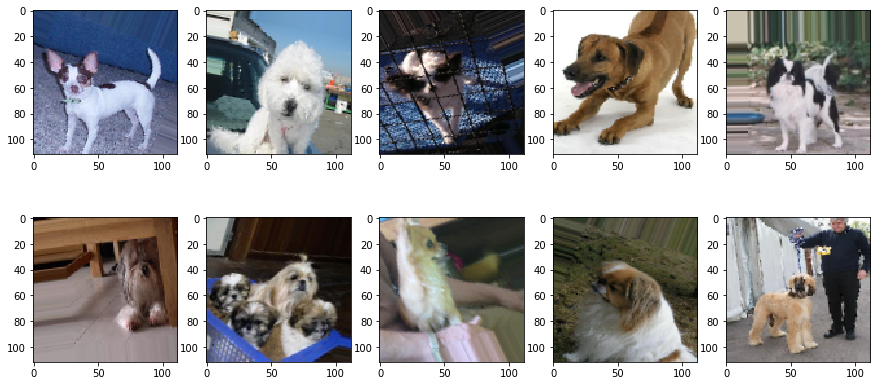

In [3]:
plt.figure()
fig,ax = plt.subplots(2,5)
fig.set_figheight(7)
fig.set_figwidth(15)
ax=ax.flatten()
X,Y=next(train_generator)
for i in range(10): ax[i].imshow(X[i,:,:,:])

### 构建MobileNet模型 

### 手写代码实现深度可分离卷积 

In [9]:
def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                           strides=(1, 1), block_id=1):

    """Adds a depthwise convolution block.

    A depthwise convolution block consists of a depthwise conv,
    batch normalization, relu6, pointwise convolution,
    batch normalization and relu6 activation.

    # Arguments

        inputs: Input tensor of shape `(rows, cols, channels)`

        pointwise_conv_filters: Integer, the dimensionality of the output space
            (i.e. the number of output filters in the pointwise convolution).

        alpha: controls the width of the network.

        strides: An integer or tuple/list of 2 integers,
            specifying the strides of the convolution
            along the width and height.

        block_id: Integer, a unique identification designating
            the block number.
            
    # Returns
        Output tensor of block.

    """

    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    if strides == (1, 1):
        x = inputs
    else:
        x = ZeroPadding2D(((0, 1), (0, 1)),
                          name='conv_pad_%d' % block_id)(inputs)

    x = DepthwiseConv2D((3, 3),
                               padding='same' if strides == (1, 1) else 'valid',
                               strides=strides,
                               use_bias=False,
                               name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(axis=-1, 
                                  name='conv_dw_%d_bn' % block_id)(x)
    x = ReLU(6., name='conv_dw_%d_relu' % block_id)(x)
    x = Conv2D(pointwise_conv_filters, (1, 1),
                      padding='same',
                      use_bias=False,
                      strides=(1, 1),
                      name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=-1,
                                  name='conv_pw_%d_bn' % block_id)(x)
    
    return ReLU(6., name='conv_pw_%d_relu' % block_id)(x)

### 搭建简版MobileNet模型

In [10]:
alpha = 1
depth_multiplier = 1

# 输入层
input_layer = Input([IMSIZE,IMSIZE,3]) 

# 初始卷积层
x = input_layer
x = ZeroPadding2D(padding = ((0,1),(0,1)),name='conv1_pad')(x)
x = Conv2D(32,(3,3),padding='valid',use_bias=False,strides=(2,2),name='conv1')(x)
x = BatchNormalization(axis=-1, name='conv1_bn')(x)
x = ReLU(6,name='conv1_relu')(x)

# 保留其中的一些深度可分离卷积层
x = _depthwise_conv_block(x, 64, alpha, block_id=1)
x = _depthwise_conv_block(x, 128, alpha, strides=(2, 2), block_id=2)
x = _depthwise_conv_block(x, 256, alpha, strides=(2, 2), block_id=3)
x = _depthwise_conv_block(x, 512, alpha, strides=(2, 2), block_id=4)
x = _depthwise_conv_block(x, 1024, alpha, strides=(2, 2), block_id=5)


# Average Pooling
x = GlobalAveragePooling2D()(x)

x = Dense(10,activation='softmax')(x)
model = Model(inputs=input_layer,outputs=x)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 112, 112, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 113, 113, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 56, 56, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 56, 56, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 56, 56, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 56, 56, 32)        128 

### 模型编译及拟合 

In [11]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=100)

Epoch 1/5
100/100 [==============================] - 150s 1s/step - loss: 1.9513 - accuracy: 0.3080 - val_loss: 2.5533 - val_accuracy: 0.1309
Epoch 2/5
100/100 [==============================] - 138s 1s/step - loss: 1.4792 - accuracy: 0.4803 - val_loss: 2.5693 - val_accuracy: 0.1316
Epoch 3/5
100/100 [==============================] - 134s 1s/step - loss: 1.0786 - accuracy: 0.6308 - val_loss: 3.6040 - val_accuracy: 0.1309
Epoch 4/5
100/100 [==============================] - 139s 1s/step - loss: 0.7555 - accuracy: 0.7466 - val_loss: 4.3272 - val_accuracy: 0.1093
Epoch 5/5
100/100 [==============================] - 133s 1s/step - loss: 0.4986 - accuracy: 0.8388 - val_loss: 3.9776 - val_accuracy: 0.1627


### 迁移学习

In [17]:
from keras.applications.mobilenet import MobileNet
base_model = MobileNet(weights='imagenet',include_top = False)
weights = base_model.get_weights()

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10,activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics = ['accuracy'])

model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=100)

Epoch 1/5
100/100 [==============================] - 141s 1s/step - loss: 1.5127 - accuracy: 0.5171 - val_loss: 1.8417 - val_accuracy: 0.5486
Epoch 2/5
100/100 [==============================] - 139s 1s/step - loss: 0.8182 - accuracy: 0.7240 - val_loss: 1.4923 - val_accuracy: 0.5655
Epoch 3/5
100/100 [==============================] - 133s 1s/step - loss: 0.6603 - accuracy: 0.7756 - val_loss: 2.7548 - val_accuracy: 0.5451
Epoch 4/5
100/100 [==============================] - 138s 1s/step - loss: 0.5647 - accuracy: 0.8115 - val_loss: 2.4208 - val_accuracy: 0.5810
Epoch 5/5
100/100 [==============================] - 133s 1s/step - loss: 0.5159 - accuracy: 0.8268 - val_loss: 2.6249 - val_accuracy: 0.5649
